In [1]:
from fastai import *
from fastai.vision.all import *
from fastai.imports import *
import cv2, os
from torchvision import transforms as T
from torchvision.transforms import functional as F
import albumentations as A
import copy
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from ImagenetDataset import ImagenetDataset

In [2]:
root = Path("D:\\tensorflow_datasets\\cifar10")

In [3]:
train_images = get_image_files(root/"train")
val_images = get_image_files(root/"test")

In [4]:
def create_df(paths):
    names = [str(img.name) for img in paths]
    labels = [str(img.parent).split("\\")[-1] for img in paths]
    data = np.array([names, labels]).T
    np.random.shuffle(data)
    return pd.DataFrame(data,columns=["image", "label"])

train_df = create_df(train_images)
train_df.head()

,image,label
0,0838.png,truck
1,3668.png,cat
2,0895.png,deer
3,4293.png,ship
4,4263.png,ship


In [5]:
valid_df = create_df(val_images)
valid_df.head()

,image,label
0,0253.png,ship
1,0043.png,airplane
2,0864.png,bird
3,0054.png,automobile
4,0090.png,truck


In [6]:
label_dict = {l:i for i,l in enumerate(train_df["label"].unique())}
label_dict

{'truck': 0,
 'cat': 1,
 'deer': 2,
 'ship': 3,
 'airplane': 4,
 'dog': 5,
 'bird': 6,
 'horse': 7,
 'frog': 8,
 'automobile': 9}

In [7]:
def randAugment(N, M, p):

    shift_x = np.linspace(0,150,10)
    shift_y = np.linspace(0,150,10)
    rot = np.linspace(0,30,10)
    shear = np.linspace(0,10,10)
    sola = np.linspace(0,256,10)
    post = [4,4,5,5,6,6,7,7,8,8]
    cont = [np.linspace(-0.8,-0.1,10),np.linspace(0.1,2,10)]
    bright = np.linspace(0.1,0.7,10)
    shar = np.linspace(0.1,0.9,10)
    cut = np.linspace(0,60,10)

    Aug =[#0 - geometrical
        A.ShiftScaleRotate(shift_limit_x=shift_x[M], rotate_limit=0, shift_limit_y=0, shift_limit=shift_x[M], p=p),
        A.ShiftScaleRotate(shift_limit_y=shift_y[M], rotate_limit=0, shift_limit_x=0, shift_limit=shift_y[M], p=p),
        A.Affine(rotate=rot[M], p=p),
        A.Affine(shear=shear[M], p=p),
        A.InvertImg(p=p),
        #5 - Color Based
        A.Equalize(p=p),
        A.Solarize(threshold=sola[M], p=p),
        A.Posterize(num_bits=post[M], p=p),
        A.RandomContrast(limit=[cont[0][M], cont[1][M]], p=p),
        A.RandomBrightness(limit=bright[M], p=p),
        A.Sharpen(alpha=shar[M], lightness=shar[M], p=p)]


    ops = np.random.choice(Aug, N)
    
    transforms = A.Compose(ops)
    return transforms, ops

C:\Users\suraj\anaconda3\lib\site-packages\albumentations\augmentations\transforms.py:1826: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
C:\Users\suraj\anaconda3\lib\site-packages\albumentations\augmentations\transforms.py:1800: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


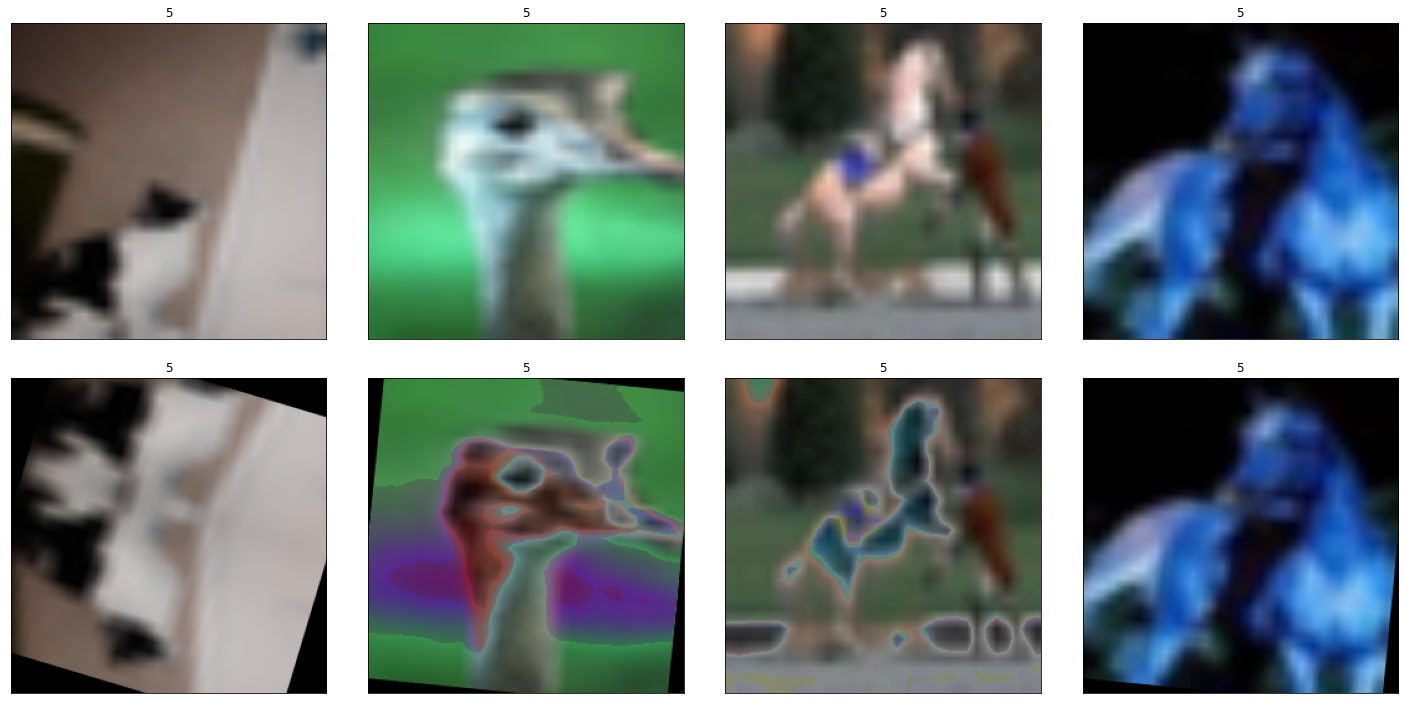

In [8]:
idx = np.random.randint(0,len(train_images)-1, 4)
fig, ax = plt.subplots(2,4, figsize=(20,10))
fig.tight_layout()
M = 5
for i in range(2):
    for j in range(4):
        img = cv2.imread(str(train_images[int(idx[j])]))
        img = cv2.resize(img,(254,254))
        if i == 1:
            transforms, ops = randAugment(2, M, 1)
            img = transforms(image=img)["image"]
        ax[i][j].get_xaxis().set_visible(False)
        ax[i][j].get_yaxis().set_visible(False)
        ax[i][j].set_title(str(M))
        ax[i][j].imshow(img)

In [9]:
len(train_df["label"].unique())

10

In [10]:
'''class ImagenetDataset(torch.utils.data.Dataset):

    def __init__(self, path, df, label_dict, dim = 256, transforms=None):
        self.df = df
        self.transforms = transforms
        self.image_paths = get_image_files(path)
        self.label_dict = label_dict
        self.dim = dim

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        label = self.label_dict[self.df[self.df["image"] == img_path.name]["label"].values[0]]
        img = A.Resize(self.dim, self.dim)(image=img)["image"]

        if self.transforms is not None:
            img = self.transforms(image=img)["image"]

        img = F.to_tensor(img)
        label = torch.as_tensor(label)
        label = torch.nn.functional.one_hot(label,len(self.df["label"].unique()))

        return img, label.float()'''

'class ImagenetDataset(torch.utils.data.Dataset):\n\n    def __init__(self, path, df, label_dict, dim = 256, transforms=None):\n        self.df = df\n        self.transforms = transforms\n        self.image_paths = get_image_files(path)\n        self.label_dict = label_dict\n        self.dim = dim\n\n    def __len__(self):\n        return len(self.image_paths)\n\n    def __getitem__(self, idx):\n        img_path = self.image_paths[idx]\n        img = cv2.imread(str(img_path))\n        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)\n        label = self.label_dict[self.df[self.df["image"] == img_path.name]["label"].values[0]]\n        img = A.Resize(self.dim, self.dim)(image=img)["image"]\n\n        if self.transforms is not None:\n            img = self.transforms(image=img)["image"]\n\n        img = F.to_tensor(img)\n        label = torch.as_tensor(label)\n        label = torch.nn.functional.one_hot(label,len(self.df["label"].unique()))\n\n        return img, label.float()'

In [11]:
dataset = ImagenetDataset(root/"train", train_df, label_dict=label_dict)
dataset.__getitem__(1)[1]

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

In [12]:
def create_dataloaders(root, train_df, valid_df, label_dict, transforms, dim = 256, bs=32):

    data_loaders = {}
    dataset_sizes = {}

    train_dataset = ImagenetDataset(path=root/"train", df=train_df, label_dict=label_dict, dim=dim, transforms=transforms)
    valid_dataset = ImagenetDataset(path=root/"test", df=valid_df, label_dict=label_dict, dim=dim)

    data_loaders["train"] = torch.utils.data.DataLoader(train_dataset, batch_size=bs,shuffle=True, num_workers=4)
    data_loaders["val"] = torch.utils.data.DataLoader(valid_dataset, batch_size=bs,shuffle=False, num_workers=4)

    dataset_sizes["train"] = len(train_dataset)
    dataset_sizes["val"] = len(valid_dataset)

    return data_loaders, dataset_sizes


In [13]:
model = models.resnet18()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model.fc

Linear(in_features=512, out_features=10, bias=True)

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [15]:
def train_model(model, criterion, optimizer, scheduler, max_M=9, num_epochs=5):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    N=2;M=0;p=0.5

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
    
        transforms, ops = randAugment(N=N, M=M, p=p)
        dataloaders, dataset_sizes = create_dataloaders(root, train_df, valid_df, label_dict, bs=2, transforms=transforms)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = torch.argmax(input = outputs, dim = 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == torch.argmax(input = labels, dim = 1))
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            elif phase == 'val' and epoch_acc < best_acc:
                stp = int((9-M)*((best_acc-epoch_acc)/best_acc))
                M += max(1,stp)
                M = min(M, max_M)
                if M < max_M:
                  print("Augmentaion Magnitude Changed To : {}\n".format(M))


    print('Best Val Acc: {:4f}'.format(best_acc))
    

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [16]:
model = models.resnet18()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model.fc
model.to(device)
param = model.parameters()
optimizer_ft=torch.optim.Adam(param, lr=0.01)
criterion=nn.BCEWithLogitsLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, max_M=5, num_epochs=5)

Epoch 0/15
----------
